Installing and Importing Python Libraries

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


Data Extraction and Cleaning

In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto = df.iloc[0].str.extractall(r'(M\d\w)([^\(\(]*)(?:\((.*)\))?')
toronto.columns =['Postalcode', 'Borough', 'Neighborhood']
toronto

,,Postalcode,Borough,Neighborhood
,match,,,
0,0,M1A,Not assigned,NaN
1,0,M2A,Not assigned,NaN
2,0,M3A,North York,Parkwoods
3,0,M4A,North York,Victoria Village
4,0,M5A,Downtown Toronto,Regent Park / Harbourfront
5,0,M6A,North York,Lawrence Manor / Lawrence Heights
6,0,M7A,Queen's Park,Ontario Provincial Government
7,0,M8A,Not assigned,NaN
8,0,M9A,Etobicoke,Islington Avenue


In [15]:
toronto_df = toronto.loc[toronto['Borough'] != 'Not assigned']
toronto_df

,,Postalcode,Borough,Neighborhood
,match,,,
2,0,M3A,North York,Parkwoods
3,0,M4A,North York,Victoria Village
4,0,M5A,Downtown Toronto,Regent Park / Harbourfront
5,0,M6A,North York,Lawrence Manor / Lawrence Heights
6,0,M7A,Queen's Park,Ontario Provincial Government
8,0,M9A,Etobicoke,Islington Avenue


In [16]:
grp = toronto_df.groupby(['Postalcode', 'Borough'])

In [17]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
     
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [18]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [19]:
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [20]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [21]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.65512,-79.36264
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188
5,M9A,Etobicoke,Islington Avenue,43.66263,-79.52831


In [22]:
df_2.shape

(6, 5)

Map of Scarborough

In [23]:
CLIENT_ID = 'S0TY0LK2TR4WL1PCGYL3PRCVUBFKVHEBC35WXLI3GSR4RTGY' # your Foursquare ID
CLIENT_SECRET = 'VMBCOT4R2H2RSADXVVVCQ0RE25M1QWI25SM15LG2NW0OD2UR' # your Foursquare Secret
ACCESS_TOKEN = '2RNIQL0GMVDHOUYZSLQJD53S01JB5PZJYXMOOSFOF1HX4VUQ' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S0TY0LK2TR4WL1PCGYL3PRCVUBFKVHEBC35WXLI3GSR4RTGY
CLIENT_SECRET:VMBCOT4R2H2RSADXVVVCQ0RE25M1QWI25SM15LG2NW0OD2UR


In [24]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.7729744 -79.2576479


In [25]:

radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [26]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.events.count',
       'venue.events.summary', 'venue.venuePage.id'],
      dtype='object')

In [27]:

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

nearby venues/locations

In [28]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
2,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
3,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


Categories of Nearby Venues/Locations

In [29]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,American Eagle Store,Clothing Store,43.776012,-79.258334
2,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
3,SEPHORA,Cosmetics Shop,43.775512,-79.258288
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


In [30]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      9
Restaurant          5
Coffee Shop         4
Gas Station         2
Pharmacy            2
Department Store    2
Sandwich Place      2
Deli / Bodega       1
Shoe Store          1
Discount Store      1
Name: categories, dtype: int64

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Ontario Provincial Government
Islington Avenue


In [33]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 102 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Islington Avenue,12,12,12,12,12,12
Lawrence Manor / Lawrence Heights,62,62,62,62,62,62
Ontario Provincial Government,55,55,55,55,55,55
Parkwoods,7,7,7,7,7,7
Regent Park / Harbourfront,88,88,88,88,88,88


In [34]:

# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,American Restaurant,Animal Shelter,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cheese Shop,Chocolate Shop,Clothing Store,Coffee Shop,College Arts Building,College Theater,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Electronics Store,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Gym Pool,Historic Site,Hobby Shop,Home Service,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Karaoke Bar,Kitchen Supply Store,Leather Goods Store,Liquor Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Museum,Office,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Platform,Pool,Portuguese Restaurant,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoothie Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sushi Restaurant,Tech Startup,Thai Restaurant,Theater,Toy / Game Store,Tram Station,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:

num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Islington Avenue ----
                 venue  freq
0             Pharmacy  0.17
1        Grocery Store  0.08
2                 Bank  0.08
3         Home Service  0.08
4  Japanese Restaurant  0.08


---- Lawrence Manor / Lawrence Heights ----
            venue  freq
0  Clothing Store  0.18
1    Dessert Shop  0.05
2   Women's Store  0.05
3       Bookstore  0.03
4     Men's Store  0.03


---- Ontario Provincial Government ----
              venue  freq
0       Coffee Shop  0.18
1    Sandwich Place  0.07
2              Café  0.07
3  Sushi Restaurant  0.04
4     Burrito Place  0.04


---- Parkwoods ----
                  venue  freq
0                  Park  0.29
1  Fast Food Restaurant  0.14
2                  Pool  0.14
3          Burger Joint  0.14
4     Food & Drink Shop  0.14


---- Regent Park / Harbourfront ----
         venue  freq
0  Coffee Shop  0.14
1         Park  0.06
2      Theater  0.05
3   Restaurant  0.05
4          Pub  0.03


---- Victoria Village ----
               

In [36]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most Common venues near neighborhood

In [37]:

import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Islington Avenue,Pharmacy,Grocery Store,Bank,Home Service,Japanese Restaurant,Park,Café,Shopping Mall,Skating Rink,Convenience Store
1,Lawrence Manor / Lawrence Heights,Clothing Store,Dessert Shop,Women's Store,Bookstore,Men's Store,Greek Restaurant,Furniture / Home Store,Fried Chicken Joint,Food Court,Cosmetics Shop
2,Ontario Provincial Government,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Burrito Place,Park,Mexican Restaurant,Pub,Dessert Shop,Japanese Restaurant
3,Parkwoods,Park,Fast Food Restaurant,Pool,Burger Joint,Food & Drink Shop,Pet Store,Mediterranean Restaurant,Office,Museum,Movie Theater
4,Regent Park / Harbourfront,Coffee Shop,Park,Theater,Restaurant,Pub,Italian Restaurant,Bakery,Café,Performing Arts Venue,Thai Restaurant


K-Means Clustering Approach

In [38]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 0, 2])

In [39]:

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last column

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,1,Park,Fast Food Restaurant,Pool,Burger Joint,Food & Drink Shop,Pet Store,Mediterranean Restaurant,Office,Museum,Movie Theater
1,M4A,North York,Victoria Village,43.73057,-79.31306,2,Pizza Place,Coffee Shop,Intersection,Portuguese Restaurant,French Restaurant,Middle Eastern Restaurant,American Restaurant,Mediterranean Restaurant,Office,Museum
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.65512,-79.36264,0,Coffee Shop,Park,Theater,Restaurant,Pub,Italian Restaurant,Bakery,Café,Performing Arts Venue,Thai Restaurant
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.72327,-79.45042,0,Clothing Store,Dessert Shop,Women's Store,Bookstore,Men's Store,Greek Restaurant,Furniture / Home Store,Fried Chicken Joint,Food Court,Cosmetics Shop
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188,0,Coffee Shop,Sandwich Place,Café,Sushi Restaurant,Burrito Place,Park,Mexican Restaurant,Pub,Dessert Shop,Japanese Restaurant


Map of Clusters

In [40]:
kclusters = 2

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#ff0000']


In [43]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,
                                                              
                                                              
                                                              ]})

In [44]:

Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

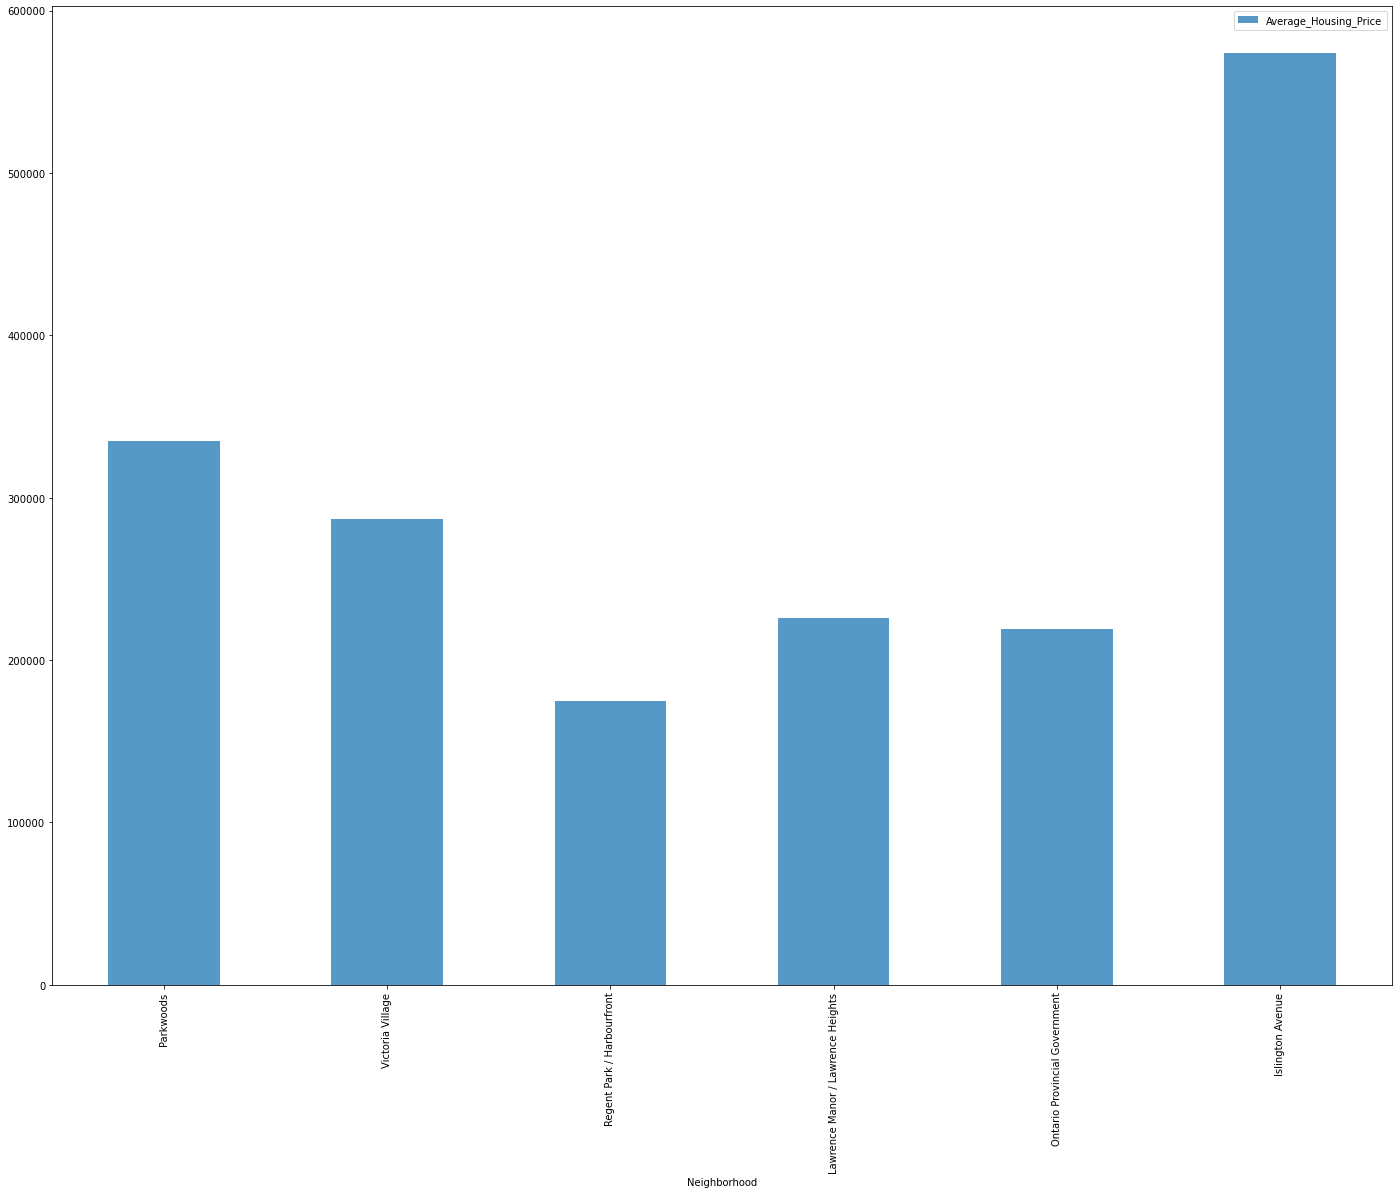

In [45]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)